In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import joblib

## Constants

In [3]:
#DATA_PATH = '../data' # Need to have the data as CSV files in this path
DATA_PATH = '../data/mini' # Need to have the data as CSV files in this path

## Scripts for loading data

In [4]:
# This is for if you need to clone the data repo and extract data csv files

# git clone https://github.com/Compensate-Operations/emission-sample-data.git

# !for i in /emission-sample-data/datasets/textile-v1.0.0/*.tgz; do tar -zxvf "$i" ;done
# !ls -lah
# !rm ._textile-v1.0.0-5.csv

In [5]:
%pwd

'C:\\Users\\mikko.kotola\\Documents\\Compensate\\carbonpredict\\notebooks'

In [37]:
content = sorted(filter(lambda x: x.endswith(".csv"), os.listdir(DATA_PATH)))

df = pd.concat((pd.read_csv(f'{DATA_PATH}/{f}') for f in content))

In [38]:
# Use only top 50 000 rows for experimentation
df = df[:50000]
df

,brand,category-1,category-2,category-3,co2_total,colour,fabric_type,ftp_acrylic,ftp_cotton,ftp_elastane,...,ftp_silk,ftp_viscose,ftp_wool,gender,label,made_in,season,size,unspsc_code,weight
0,b111,womenswear,uniform,jacket,NaN,blue gray,K,NaN,NaN,NaN,...,NaN,NaN,NaN,W,NaN,TR,NaN,XS,NaN,1.062
1,b82,home,home,curtain,NaN,teal,W,NaN,11.0,5.0,...,NaN,NaN,68.0,NaN,NaN,PK,NaN,XXL,NaN,NaN
2,b107,menswear,headgear,knit-cap,NaN,metal,K,3.0,NaN,4.0,...,89.0,2.0,NaN,M,NaN,PK,NaN,XL,NaN,0.160
3,b111,home,home,curtain,NaN,light grey,K,NaN,NaN,23.0,...,1.0,5.0,NaN,NaN,NaN,TR,NaN,M,NaN,NaN
4,b83,womenswear,footwear,socks,NaN,bondi blue,K,21.0,NaN,NaN,...,NaN,NaN,11.0,W,NaN,VN,NaN,M,NaN,0.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,b98,home,home,mat,NaN,wheat,W,15.0,NaN,NaN,...,17.0,NaN,NaN,NaN,NaN,KR,NaN,M,NaN,NaN
49996,b89,kidswear,dress,evening-dress,10.36,light grey,K,6.0,NaN,4.0,...,87.0,NaN,NaN,B,NaN,CN,NaN,L,NaN,NaN
49997,b96,kidswear,suit,coats,NaN,amber,K,NaN,73.0,NaN,...,1.0,10.0,NaN,K,NaN,GB,MID,XS,NaN,NaN
49998,b69,kidswear,uniform,trousers,NaN,turquoise,W,NaN,9.0,9.0,...,6.0,NaN,52.0,G,NaN,CN,WIN,XS,NaN,NaN


## Preprocessing

In [39]:
# Drop empty features (dataset v. 1.0.0): unspsc_code, label 
df = df.drop(['label', 'unspsc_code'], axis=1)

# Use ordered categories for size
size_type = CategoricalDtype(categories=["XS", "S", "M", "L", "XL", "XXL"], ordered=True)
df["size"].astype(size_type)

0         XS
1        XXL
2         XL
3          M
4          M
        ... 
49995      M
49996      L
49997     XS
49998     XS
49999     XS
Name: size, Length: 50000, dtype: category
Categories (6, object): [XS < S < M < L < XL < XXL]

In [40]:
df

,brand,category-1,category-2,category-3,co2_total,colour,fabric_type,ftp_acrylic,ftp_cotton,ftp_elastane,...,ftp_polyester,ftp_polypropylene,ftp_silk,ftp_viscose,ftp_wool,gender,made_in,season,size,weight
0,b111,womenswear,uniform,jacket,NaN,blue gray,K,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,W,TR,NaN,XS,1.062
1,b82,home,home,curtain,NaN,teal,W,NaN,11.0,5.0,...,7.0,4.0,NaN,NaN,68.0,NaN,PK,NaN,XXL,NaN
2,b107,menswear,headgear,knit-cap,NaN,metal,K,3.0,NaN,4.0,...,NaN,NaN,89.0,2.0,NaN,M,PK,NaN,XL,0.160
3,b111,home,home,curtain,NaN,light grey,K,NaN,NaN,23.0,...,NaN,8.0,1.0,5.0,NaN,NaN,TR,NaN,M,NaN
4,b83,womenswear,footwear,socks,NaN,bondi blue,K,21.0,NaN,NaN,...,NaN,24.0,NaN,NaN,11.0,W,VN,NaN,M,0.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,b98,home,home,mat,NaN,wheat,W,15.0,NaN,NaN,...,7.0,NaN,17.0,NaN,NaN,NaN,KR,NaN,M,NaN
49996,b89,kidswear,dress,evening-dress,10.36,light grey,K,6.0,NaN,4.0,...,NaN,2.0,87.0,NaN,NaN,B,CN,NaN,L,NaN
49997,b96,kidswear,suit,coats,NaN,amber,K,NaN,73.0,NaN,...,NaN,5.0,1.0,10.0,NaN,K,GB,MID,XS,NaN
49998,b69,kidswear,uniform,trousers,NaN,turquoise,W,NaN,9.0,9.0,...,NaN,9.0,6.0,NaN,52.0,G,CN,WIN,XS,NaN


In [41]:
df_co2 = df[~df["co2_total"].isna()]

## Train-test-split

Try first using just the subset of source data with CO2 targets present.

In [42]:
y = df_co2["co2_total"]
df_co2 = df_co2.drop(["co2_total"], axis=1)
columns_to_include = ["category-1", "category-2", "category-3", "fabric_type", "size"]
#columns_to_include = ["brand", "category-1", "category-2", "category-3", "colour", "fabric_type", "made_in", "size"]
df_co2_small = pd.DataFrame(columns=columns_to_include, data=df_co2[columns_to_include].values)

In [43]:
df_co2

,brand,category-1,category-2,category-3,colour,fabric_type,ftp_acrylic,ftp_cotton,ftp_elastane,ftp_linen,...,ftp_polyester,ftp_polypropylene,ftp_silk,ftp_viscose,ftp_wool,gender,made_in,season,size,weight
23,b101,womenswear,headgear,flat-cap,light brown,K,NaN,12.0,6.0,1.0,...,7.0,NaN,61.0,NaN,NaN,W,TR,NaN,S,0.122
34,b131,clothing,accessory,backpack,unbleached,K,NaN,9.0,6.0,NaN,...,6.0,NaN,NaN,NaN,69.0,W,CN,NaN,M,NaN
51,b76,baby,thermals,trousers,purple,K,NaN,NaN,10.0,NaN,...,6.0,3.0,69.0,NaN,6.0,NaN,US,AYR,M,NaN
56,b86,menswear,swimwear,swimsuit,natural,K,NaN,NaN,NaN,31.0,...,45.0,8.0,NaN,NaN,NaN,M,HK,NaN,XS,NaN
74,b131,kidswear,thermals,trousers,green,K,8.0,2.0,14.0,NaN,...,36.0,14.0,3.0,6.0,NaN,B,ES,MID,XXL,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49947,b16,home,home,mat,blue gray,K,NaN,39.0,NaN,9.0,...,8.0,NaN,NaN,NaN,25.0,NaN,CN,NaN,L,2.782
49955,b112,kidswear,undergarments,underpants,light grey,K,NaN,NaN,NaN,21.0,...,NaN,NaN,NaN,19.0,NaN,K,CN,NaN,XS,0.019
49965,b67,kidswear,accessory,backpack,light grey,K,NaN,18.0,NaN,33.0,...,2.0,14.0,18.0,13.0,NaN,Y,US,NaN,M,NaN
49968,b17,home,home,curtain,lime,W,12.0,12.0,NaN,4.0,...,1.0,NaN,4.0,NaN,NaN,NaN,CN,NaN,L,NaN


In [44]:
df_co2_small

,category-1,category-2,category-3,fabric_type,size
0,womenswear,headgear,flat-cap,K,S
1,clothing,accessory,backpack,K,M
2,baby,thermals,trousers,K,M
3,menswear,swimwear,swimsuit,K,XS
4,kidswear,thermals,trousers,K,XXL
...,...,...,...,...,...
5568,home,home,mat,K,L
5569,kidswear,undergarments,underpants,K,XS
5570,kidswear,accessory,backpack,K,M
5571,home,home,curtain,W,L


In [45]:
# Convert the categoricals into a one-hot vector of binary variables
df_co2_small_bin = pd.get_dummies(df_co2_small)

In [46]:
df_co2_small_bin

,category-1_baby,category-1_clothing,category-1_home,category-1_kidswear,category-1_menswear,category-1_womenswear,category-2_accessory,category-2_baby,category-2_beachwear,category-2_clothing,...,category-3_underpants,category-3_wedding-dress,fabric_type_K,fabric_type_W,size_L,size_M,size_S,size_XL,size_XS,size_XXL
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5568,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
5569,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
5570,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
5571,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_co2_small_bin, y, test_size=0.2, random_state=42)

In [49]:
X_train[X_train.isnull().any(axis=1)]
# No nulls present

,category-1_baby,category-1_clothing,category-1_home,category-1_kidswear,category-1_menswear,category-1_womenswear,category-2_accessory,category-2_baby,category-2_beachwear,category-2_clothing,...,category-3_underpants,category-3_wedding-dress,fabric_type_K,fabric_type_W,size_L,size_M,size_S,size_XL,size_XS,size_XXL


## Clustering using k-nearest neighbors

In [50]:
n_neighbors = 10

In [51]:
nbrs = neighbors.NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

In [52]:
# Save model to disk or load model from disk
filename = f"nearestneighbor_{n_neighbors}.sav"
savemodel = False
loadmodel = False
if (savemodel):
    joblib.dump(nbrs, f"{DATA_PATH}/{filename}")
if (loadmodel):
    nbrs = joblib.load(f"{DATA_PATH}/{filename}")

In [53]:
distances[0:5,]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.41421356, 1.41421356,
        1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356],
       [0.        , 0.        , 0.        , 0.        , 1.41421356,
        1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356],
       [0.        , 0.        , 0.        , 1.41421356, 1.41421356,
        1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [54]:
indices[0:5]

array([[2483, 4250, 3259, 3755, 1072, 2642, 2839,    0,  758, 3811],
       [4251,    1, 3669, 1254, 1108, 1718, 2113, 1176, 2903, 3005],
       [1213,  650, 3926,    2, 2691, 2723, 2733,   52, 3829, 2015],
       [ 242, 1595,    3, 1818,  646, 1547,   30, 1278, 2305,  161],
       [ 803,  115,  412, 1726, 3205, 1912, 1379,  678, 3832, 2447]],
      dtype=int64)

## Baseline predictions using k-nearest neigbors regression

### Search for a good k using small subset

In [55]:
number_to_try = 15
losses = np.zeros((number_to_try+1), dtype=np.float64)
for n in range(2,number_to_try+1):
    knn = neighbors.KNeighborsRegressor(n, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    # Use simple MSE
    elementwise_loss = np.square(y_test-y_pred)
    losses[n] = np.sum(elementwise_loss)

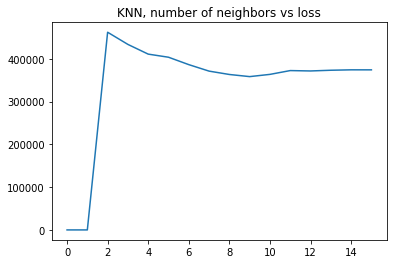

In [56]:
ax = sns.lineplot(x=range(number_to_try+1), y=losses).set_title("KNN, number of neighbors vs loss")

K = 9 would seem to work best. Use it for baseline.

In [57]:
n_neighbors = 9
knn = neighbors.KNeighborsRegressor(n, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')

In [60]:
# Save model to disk or load model from disk
filename = f"nearestneighbor_regression_{n_neighbors}.sav"
savemodel = False
loadmodel = False
if (savemodel):
    joblib.dump(knn, f"{DATA_PATH}/{filename}")
if (loadmodel):
    knn = joblib.load(f"{DATA_PATH}/{filename}")

In [61]:
y_pred[0:5]

array([ 0.60866667,  0.71933333, 10.65133333, 11.82533333, 14.464     ])

In [62]:
y_test[0:5]

32964    1.21
31502    0.42
6680     5.62
30153    5.46
4455     2.51
Name: co2_total, dtype: float64

In [63]:
# Use simple MSE
elementwise_loss = np.square(y_test-y_pred)
loss = np.sum(elementwise_loss)

In [64]:
loss

374233.5457057778

In [65]:
elementwise_loss

32964      0.361602
31502      0.089600
6680      25.314315
30153     40.517468
4455     142.898116
            ...    
26383    258.030678
48957      1.092722
28937      0.183184
33798      8.769495
25842    193.006187
Name: co2_total, Length: 1115, dtype: float64

## Predict CO2e values using baseline k-nearest neighbors regression (k=4)

### Prepare a set of samples to predict for

In [66]:
samples_no_co2 = df[df["co2_total"].isna()]
samples_small = pd.DataFrame(columns=columns_to_include, data=samples_no_co2[columns_to_include].values)
samples_small_bin = pd.get_dummies(samples_small)

In [67]:
samples_small_bin

,category-1_baby,category-1_clothing,category-1_home,category-1_kidswear,category-1_menswear,category-1_womenswear,category-2_accessory,category-2_baby,category-2_beachwear,category-2_clothing,...,category-3_underpants,category-3_wedding-dress,fabric_type_K,fabric_type_W,size_L,size_M,size_S,size_XL,size_XS,size_XXL
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44422,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
44423,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
44424,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
44425,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [69]:
samples_pred = knn.predict(samples_small_bin)

In [71]:
samples_pred[0:10]

array([16.49      , 22.976     ,  4.32866667, 16.76933333,  0.94866667,
       11.03066667,  2.376     ,  7.624     , 47.39533333,  5.29533333])